In [38]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import skimage
from glob import glob
import os
import time
import pytz
from datetime import datetime, timedelta
import wget
import json
sys.path.insert(1, './scripts')
%matplotlib inline
import pyproj
from helper_functions import *
from PIL import Image, ImageOps
import warnings 
warnings.filterwarnings('ignore') 
from IPython.display import clear_output
import s3fs 
import zarr
from satpy.writers import get_enhanced_image


In [39]:
#dt_str = '2024/06/18 15:00'
dt_str = '2024/09/12 14:05'
dt_str = '2024/07/15 23:55'

dt = pytz.utc.localize(datetime.strptime(dt_str, '%Y/%m/%d %H:%M')) # convert to datetime object
#dt = pytz.utc.localize(datetime.utcnow()-timedelta(minutes=200))
print(dt)

2024-07-15 23:55:00+00:00


sunrise on the west coast is at 13:40 UTC for 2024/07/15
sunset on the east coast is at 03:09 UTC for 2024/07/16
DOWNLOADING SMOKE:
hms_smoke20240715.zip
./data/smoke/hms_smoke20240715.zip
hms_smoke20240715.zip already exists

there are 10 smoke annotations in the time period requested


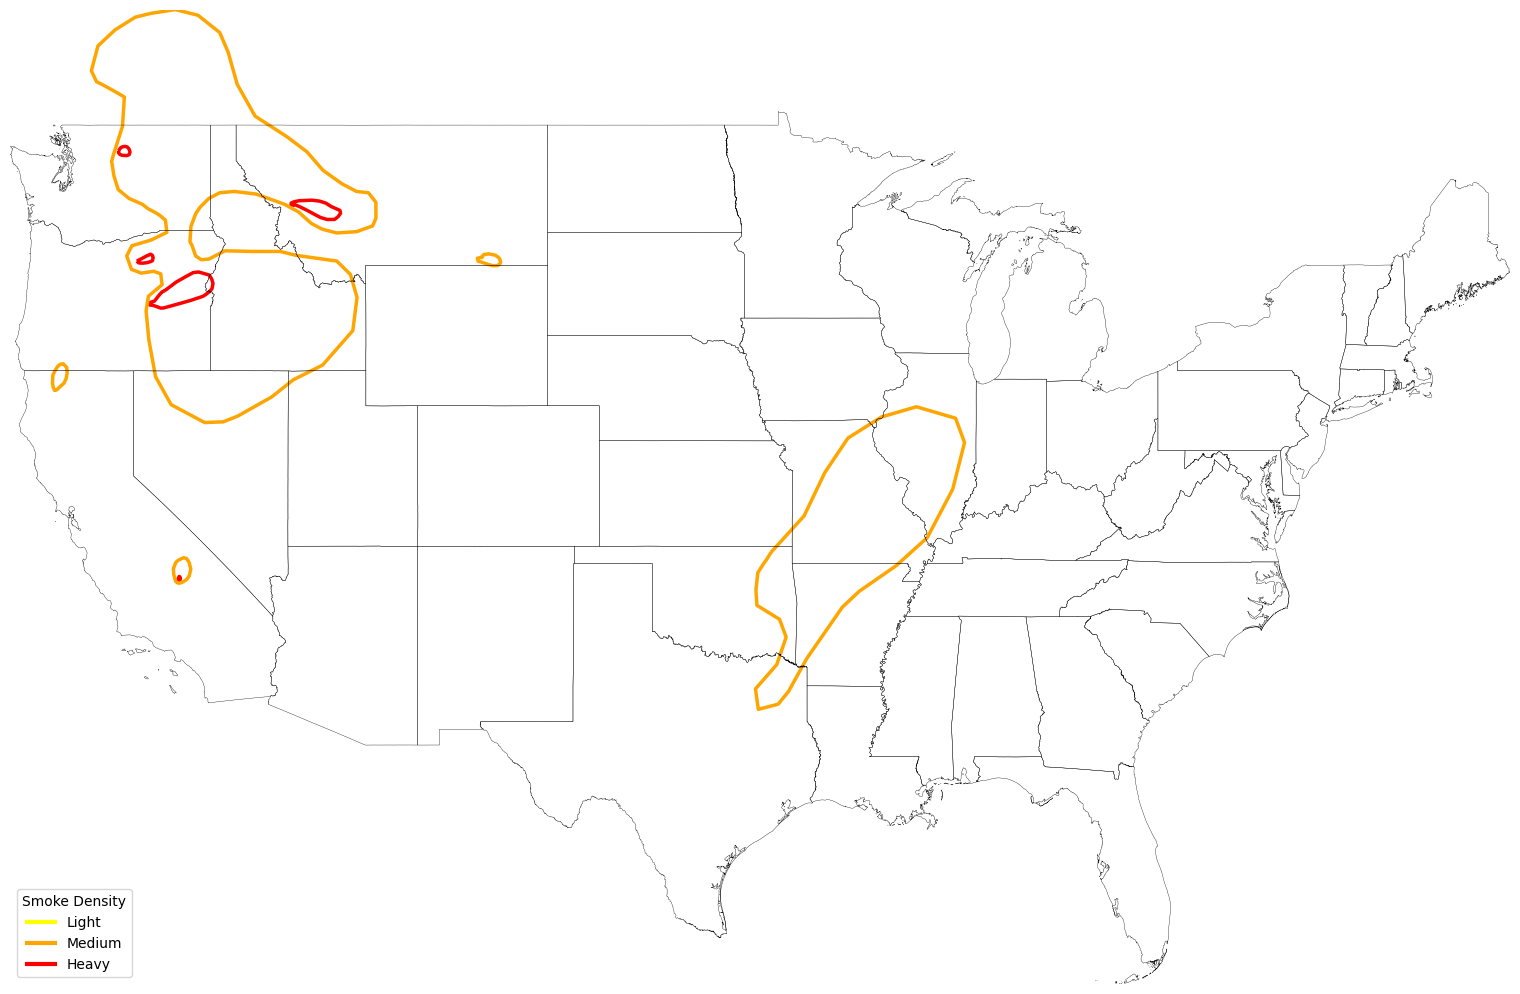

In [40]:
from grab_smoke import download_smoke #/scripts/grab_smoke.py
#smoke_shp = download_smoke(dt, entire_day=True)
smoke_shp = download_smoke(dt, entire_day=False)

Using [geopandas](https://geopandas.org/en/stable/) we can convert the .shp files into python database objects so that the data can be easily accessed.

In [41]:
display(smoke_shp)
#display(smoke_shp.head())

,Satellite,Start,End,Density,geometry
25,GOES-WEST,2024197 1930,2024198 0000,Heavy,"POLYGON ((-118.32881 35.97922, -118.29448 36.0..."
13,GOES-WEST,2024197 1930,2024198 0000,Medium,"POLYGON ((-118.32881 35.96396, -118.38603 36.0..."
16,GOES-WEST,2024197 1930,2024198 0000,Medium,"POLYGON ((-95.43059 36.82541, -94.1573 37.8622..."
14,GOES-WEST,2024197 1930,2024198 0000,Medium,"POLYGON ((-123.07936 41.46838, -123.12575 41.6..."
26,GOES-WEST,2024197 1930,2024198 0000,Heavy,"POLYGON ((-118.8081 44.27609, -118.35415 44.52..."
15,GOES-WEST,2024197 1930,2024198 0000,Medium,"POLYGON ((-106.55303 45.30697, -106.30156 45.3..."
27,GOES-WEST,2024197 1930,2024198 0000,Heavy,"POLYGON ((-119.8755 45.12181, -119.6695 45.201..."
12,GOES-WEST,2024197 1930,2024198 0000,Medium,"POLYGON ((-120.77327 48.16319, -120.42766 48.9..."
28,GOES-WEST,2024197 1930,2024198 0000,Heavy,"POLYGON ((-113.86976 46.71044, -113.7599 46.72..."
29,GOES-WEST,2024197 1930,2024198 0000,Heavy,"POLYGON ((-120.58003 48.26646, -120.5316 48.31..."


In [42]:
from grab_goes import download_goes # ./scripts/grab_goes.py
sat_fns = download_goes(dt, scope='F', sat_num='16')
fn_head = sat_fns[0].split('C01_')[-1].split('.')[0].split('_c2')[0]

for the datetime 2024-07-15 23:55:00+00:00:
sunrise is at: 2024-07-15 13:40:12+00:00
sunset is at: 2024-07-15 00:30:36+00:00
downloading OR_ABI-L1b-RadF-M6C01_G16_s20241972350211_e20241972359519_c20241972359556.nc
downloading OR_ABI-L1b-RadF-M6C02_G16_s20241972350211_e20241972359519_c20241972359551.nc
downloading OR_ABI-L1b-RadF-M6C03_G16_s20241972350211_e20241972359519_c20241972359565.nc


In [43]:
print(sat_fns)

['./data/goes/OR_ABI-L1b-RadF-M6C01_G16_s20241972350211_e20241972359519_c20241972359556.nc', './data/goes/OR_ABI-L1b-RadF-M6C02_G16_s20241972350211_e20241972359519_c20241972359551.nc', './data/goes/OR_ABI-L1b-RadF-M6C03_G16_s20241972350211_e20241972359519_c20241972359565.nc']


In [44]:
composite = ['cimss_true_color_sunz_rayleigh'] # define the true color composite
import cartopy.crs as ccrs
def get_proj():
    
    lcc_proj = ccrs.LambertConformal(central_longitude=262.5,
                                     central_latitude=38.5,
                                     standard_parallels=(38.5, 38.5),
                                     globe=ccrs.Globe(semimajor_axis=6371229,
                                                      semiminor_axis=6371229))
    return lcc_proj
x0 = -2.4e6
y0 = -1.6e6
x1 = 2.72e6
y1 = 1.472e6
extent = [x0, y0, x1, y1]
#extent=[-2.4e6, -1.5e6, 2.3e6, 1.4e6] # extent for CONUS in meters for LCC projection

In [45]:
from satpy import Scene
from pyresample import create_area_def

# get the Satpy Scene object
def get_scn(fns, to_load, extent, res=3000, proj=get_proj(), reader='abi_l1b', print_info=False):
    scn = Scene(reader=reader, filenames=fns)    
    scn.load(to_load, generate=False)
    my_area = create_area_def(area_id='my_area',
                              projection=proj,
                              resolution=res,
                              area_extent=extent
                              )
    if print_info:
        print("Available channels in the Scene object:\n", scn.available_dataset_names())
        print("\nAvailable composites:\n", scn.available_composite_names())
        print("\nArea definitition:\n",my_area)    
    new_scn = scn.resample(my_area) # resamples datasets and resturns a new scene object
    return new_scn
    
res = 2000 # 5km resolution
scn = get_scn(sat_fns, composite, extent, res, print_info=True) # get satpy scn object
conus_crs = scn[composite[0]].attrs['area'].to_cartopy_crs() # the crs object will have the area extent for plotting

Available channels in the Scene object:
 ['C01', 'C02', 'C03']

Available composites:
 ['cimss_green', 'cimss_green_sunz', 'cimss_green_sunz_rayleigh', 'cimss_true_color', 'cimss_true_color_sunz', 'cimss_true_color_sunz_rayleigh', 'color_infrared', 'green', 'green_crefl', 'green_nocorr', 'green_raw', 'rey', 'true_color', 'true_color_crefl', 'true_color_nocorr', 'true_color_raw', 'true_color_reproduction', 'true_color_reproduction_corr', 'true_color_reproduction_uncorr']

Area definitition:
 Area ID: my_area
Description: my_area
Projection: {'R': '6371229', 'lat_0': '38.5', 'lat_1': '38.5', 'lat_2': '38.5', 'lon_0': '262.5', 'no_defs': 'None', 'proj': 'lcc', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 2560
Number of rows: 1536
Area extent: (-2400000.0, -1600000.0, 2720000.0, 1472000.0)


In [46]:
def get_RGB(scn, composite):
    RGB = get_enhanced_image(scn[composite]).data.compute().data
    RGB = np.einsum('ijk->jki', RGB)
    RGB[np.isnan(RGB)] = 0
    return RGB
RGB = get_RGB(scn, composite[0]) # from the scene object, extract RGB data for plotting

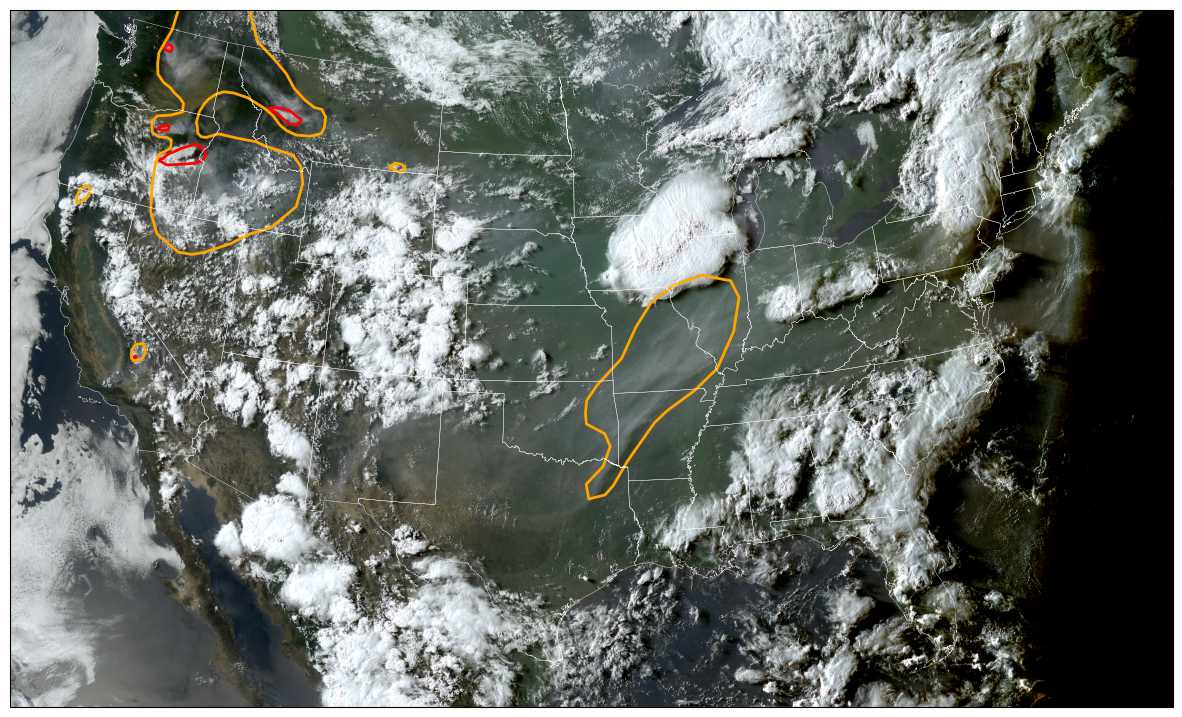

In [47]:
def plot_CONUS(data, crs, smoke_shp):
    states = get_states(crs) # ./scripts/helper_functions.py
    smoke = smoke_shp.to_crs(crs)
    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection=crs)
    smoke.loc[smoke['Density'] == 'Heavy'].plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
    smoke.loc[smoke['Density'] == 'Medium'].plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=2)
    smoke.loc[smoke['Density'] == 'Light'].plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=2)
    plt.imshow(data, transform=crs, extent=crs.bounds, origin='upper')
    states.boundary.plot(ax=ax, edgecolor='white', linewidth=.25)
    #plt.axis('off')
    #fig.tight_layout()
    #plt.savefig('conus.png')
    plt.show()
plot_CONUS(RGB, conus_crs, smoke_shp)

In [ ]:
def plot_data(data):
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(data)    
    plt.axis('off')
    fig.tight_layout()
    plt.show()    

def split_img(full_image, img_size=256):
    n_row = int(full_image.shape[0]/img_size)
    n_col = int(full_image.shape[1]/img_size)
    full_image = full_image[0:int(n_row*img_size),0:int(n_col*img_size)][:]
    fig, ax = plt.subplots(n_row, n_col, figsize=(n_col*3,n_row*3))
    for row in range(n_row):
        for col in range(n_col):
            ax[row][col].imshow(full_image[int(row*img_size):int((row+1)*img_size),int(col*img_size):int((col+1)*img_size)][:])
            ax[row][col].set_yticks([])
            ax[row][col].set_xticks([])
    plt.axis('off')
    fig.tight_layout()
    plt.show()
split_img(RGB)

In [49]:
def plot_truth(x, y, lcc_proj, smoke, png_fn):
    #fig = plt.figure(figsize=(img_shape[2]/100, img_shape[1]/100), dpi=100)
    fig = plt.figure(figsize=(len(x)/100, len(y)/100), dpi=100)
    ax = fig.add_subplot(1, 1, 1, projection=lcc_proj)
    smoke.plot(ax=ax, facecolor='black')
    #states = get_states(lcc_proj)
    #states.boundary.plot(ax=ax, edgecolor='red', linewidth=.5)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    ax.axis('off')
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.savefig(png_fn, dpi=100)
    plt.close(fig)
    #plt.show()
    img = Image.open(png_fn)
    bw = img.convert('1')
    bw = ImageOps.invert(bw)
    truth = np.asarray(bw).astype('i')
    #fig = plt.figure(figsize=(15, 12))
    #plt.imshow(truth, cmap='Greys')
    #plt.axis('off')
    #fig.tight_layout()
    #plt.show()
    #truth = reshape(truth, idx)
    #os.remove(png_fn)
    return truth

def plot_CONUS(data, crs):
    states = get_states(crs) # ./scripts/helper_functions.py
    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection=crs)
    plt.imshow(data, transform=crs, extent=crs.bounds, origin='upper')
    states.boundary.plot(ax=ax, edgecolor='white', linewidth=.25)
    plt.axis('off')
    fig.tight_layout()
    #plt.savefig('conus.png')
    plt.show()

In [50]:
def get_truth(x, y, lcc_proj, smoke, png_fn='temp.png'):
    smoke = smoke.to_crs(lcc_proj)
    low_smoke = smoke.loc[smoke['Density'] == 'Light']
    med_smoke = smoke.loc[smoke['Density'] == 'Medium']
    high_smoke = smoke.loc[smoke['Density'] == 'Heavy']

    # high = [1,1,1], med = [0, 1, 1], low = [0, 0, 1]
    low_truth = plot_truth(x, y, lcc_proj, low_smoke, png_fn)
    med_truth = plot_truth(x, y, lcc_proj, med_smoke, png_fn)
    high_truth = plot_truth(x, y, lcc_proj, high_smoke, png_fn)
    low_truth += med_truth + high_truth
    low_truth = np.clip(low_truth, 0, 1)
    med_truth += high_truth
    med_truth = np.clip(med_truth, 0, 1)
    truth_layers = np.dstack([high_truth, med_truth, low_truth])
    return truth_layers

In [51]:
x = scn['cimss_true_color_sunz_rayleigh'].coords['x']
y = scn['cimss_true_color_sunz_rayleigh'].coords['y']
truth = get_truth(x, y, conus_crs, smoke_shp)

In [52]:
def get_density(truth):
    if np.sum(truth) > 0:
        if np.sum(truth[:,:, 0]) > 0:
            return 'Heavy'
        if np.sum(truth[:,:, 1]) > 0:
            return 'Medium'
        if np.sum(truth[:,:, 2]) > 0:
            return 'Light'
    else:
        return 'None'

def split_and_save(full_image, full_truth, full_coords, fn_head, img_size=256):
    yr = fn_head.split('s')[1][0:4]
    n_row = int(full_image.shape[0]/img_size)
    n_col = int(full_image.shape[1]/img_size)
    full_image = full_image[0:int(n_row*img_size),0:int(n_col*img_size)][:]
    full_truth = full_truth[0:int(n_row*img_size),0:int(n_col*img_size)][:]
    full_coords = full_coords[0:int(n_row*img_size),0:int(n_col*img_size)][:]
    print(full_image.shape)
    fn_list = []
    for row in range(n_row):
        for col in range(n_col):
            data = full_image[int(row*img_size):int((row+1)*img_size),int(col*img_size):int((col+1)*img_size)][:]
            truth = full_truth[int(row*img_size):int((row+1)*img_size),int(col*img_size):int((col+1)*img_size)][:]
            coords = full_coords[int(row*img_size):int((row+1)*img_size),int(col*img_size):int((col+1)*img_size)][:]
            fn = '{}_2km_{}_{}.tif'.format(fn_head, row, col)
            density = get_density(truth)
            skimage.io.imsave('./data/data/{}/{}/{}'.format(yr, density, fn), data)
            skimage.io.imsave('./data/truth/{}/{}/{}'.format(yr, density, fn), truth)
            skimage.io.imsave('./data/coords/{}/{}/{}'.format(yr, density, fn), coords)
            fn_list.append(fn)

    return fn_list

In [53]:
lon, lat = scn['cimss_true_color_sunz_rayleigh'].attrs['area'].get_lonlats()
lat_lon = np.dstack([lat, lon])
tif_fns = split_and_save(RGB, truth, lat_lon, fn_head)

(1536, 2560, 3)


In [ ]:
def get_mesh(num_pixels):
    x = np.linspace(0,num_pixels-1,num_pixels)
    y = np.linspace(0,num_pixels-1,num_pixels)
    X, Y = np.meshgrid(x,y)
    return X,Y

def plot_all(fn_head, data_loc='./data/'):
    n_row = 6
    n_col = 10
    fig, ax = plt.subplots(n_row, n_col, figsize=(n_col*3,n_row*3))
    for row in range(n_row):
        for col in range(n_col):
            data_fn = glob("{}data/*/*/{}_{}_{}.tif".format(data_loc,fn_head,row,col))[0]
            RGB = skimage.io.imread(data_fn, plugin='tifffile')
            num_pixels = RGB.shape[1]
            X, Y = get_mesh(num_pixels)
            colors = ['red', 'orange', 'yellow']
            truth_fn = glob("{}truth/*/*/{}_{}_{}.tif".format(data_loc,fn_head,row,col))[0]
            truths = skimage.io.imread(truth_fn, plugin='tifffile')
            for idx in reversed(range(3)):
                ax[row][col].contour(X,Y,truths[:,:,idx],levels =[.99],colors=[colors[idx]])
            ax[row][col].imshow(RGB)
            ax[row][col].set_yticks([])
            ax[row][col].set_xticks([])
    plt.axis('off')
    fig.tight_layout()
    plt.show()
plot_all(fn_head+'_2km')

In [ ]:
from plot_tifs import plot_densities_from_processed_data # code located in /scripts/plot_tifs.py
%matplotlib inline

def cycle_through_imagery(data_loc="./data/"):
    for fn in tif_fns:
        print(fn)
        plot_densities_from_processed_data(fn, data_loc, close=True)
        x = input('press enter for next, type anything to end:')
        if x != '':
            break
        clear_output()
cycle_through_imagery()

In [56]:
import segmentation_models_pytorch as smp
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
from torchvision import transforms
import torch.nn as nn
from today_list import data_dict_from_tif_filelist

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")                                                                                                                        
print(device)

cpu


In [58]:
data_dict = data_dict_from_tif_filelist(tif_fns)
#data_dict = data_dict_from_tif_filelist(['G16_s20241701501183_e20241701503556_2_0.tif'])

In [59]:
print(len(data_dict['test']['truth']))
print(len(data_dict['test']['data']))
print((data_dict['test']['truth']))
print((data_dict['test']['data']))

60
60
['./data/truth/2024/None/G16_s20241972350211_e20241972359519_2km_0_0.tif', './data/truth/2024/Heavy/G16_s20241972350211_e20241972359519_2km_0_1.tif', './data/truth/2024/Heavy/G16_s20241972350211_e20241972359519_2km_0_2.tif', './data/truth/2024/None/G16_s20241972350211_e20241972359519_2km_0_3.tif', './data/truth/2024/None/G16_s20241972350211_e20241972359519_2km_0_4.tif', './data/truth/2024/None/G16_s20241972350211_e20241972359519_2km_0_5.tif', './data/truth/2024/None/G16_s20241972350211_e20241972359519_2km_0_6.tif', './data/truth/2024/None/G16_s20241972350211_e20241972359519_2km_0_7.tif', './data/truth/2024/None/G16_s20241972350211_e20241972359519_2km_0_8.tif', './data/truth/2024/None/G16_s20241972350211_e20241972359519_2km_0_9.tif', './data/truth/2024/Medium/G16_s20241972350211_e20241972359519_2km_1_0.tif', './data/truth/2024/Heavy/G16_s20241972350211_e20241972359519_2km_1_1.tif', './data/truth/2024/Medium/G16_s20241972350211_e20241972359519_2km_1_2.tif', './data/truth/2024/Mediu

In [62]:
#print(json.dumps(data_dict, indent=4))

In [63]:
class SmokeDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.data_fns = data_dict
        self.transform = transform
    def __len__(self):
        return len(self.data_fns['data'])
    def __getitem__(self, idx):
        data_fn = self.data_fns['data'][idx]
        truth_fn = self.data_fns['truth'][idx]
        data_img = skimage.io.imread(data_fn, plugin='tifffile')
        truth_img = skimage.io.imread(truth_fn, plugin='tifffile')
        data_tensor = self.transform(data_img)
        truth_tensor = self.transform(truth_img)
        truth_tensor = truth_tensor.type(torch.float)
        return data_tensor, truth_tensor, data_fn.split('/')[-1]
        
data_transforms = transforms.Compose([transforms.ToTensor()])
test_set = SmokeDataset(data_dict['test'], data_transforms)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=1, shuffle=False, drop_last=True)
print('there are {} items in the dataset'.format(len(test_loader)))

there are 60 items in the dataset


In [64]:
model_0 = smp.DeepLabV3Plus(                                                                                                                                   
        encoder_name="timm-efficientnet-b2",                                                                                                                 
        encoder_weights="imagenet", # use `imagenet` pre-trained weights for encoder initialization                                                          
        in_channels=3, # model input channels                                                                                                                
        classes=3, # model output channels                                                                                                                   
)   
chkpt_pth = 'models/DeepLabV3Plus_exp1_1726214171.pth'

chkpt = torch.load(chkpt_pth, map_location=torch.device('cpu'))
model_0 = model_0.to(device)
model_0.load_state_dict(chkpt['model_state_dict'])
model_0.eval()
torch.set_grad_enabled(False)


In [65]:
model_1 = smp.DeepLabV3Plus(                                                                                                                                   
        encoder_name="timm-efficientnet-b6",                                                                                                                 
        encoder_weights=None, # use `imagenet` pre-trained weights for encoder initialization                                                          
        in_channels=3, # model input channels                                                                                                                
        classes=3, # model output channels                                                                                                                   
)   
chkpt_pth = 'models/DeepLabV3Plus_exp2_1727768541.pth'
#chkpt_pth = 'models/DeepLabV3Plus_exp1_1725626205.pth'
#chkpt_pth = 'models/DeepLabV3Plus_exp1_1725707229.pth'

chkpt = torch.load(chkpt_pth, map_location=torch.device('cpu'))
model_1 = model_1.to(device)
model_1.load_state_dict(chkpt['model_state_dict'])
model_1.eval()
torch.set_grad_enabled(False)

In [66]:
def compute_iou(preds, truths):
    densities = ['high', 'medium', 'low']
    for idx, level in enumerate(densities):
        true = truths[:,idx,:,:]
        pred = preds[:,idx,:,:]
        intersection = (pred + true == 2).sum()
        union = (pred + true >= 1).sum()
        iou = intersection / union
        print('{} density smoke gives: {} IoU'.format(level, iou))

In [75]:
def compute_all_iou(model_out, truths):
    densities = ['high', 'medium', 'low']
    iou_dict = {'high': {'intersection': 0, 'union': 0}, 
                'medium': {'intersection': 0, 'union': 0},
                'low': {'intersection': 0, 'union': 0},
                'all': {'intersection': 0, 'union': 0}}

    for sample, out in enumerate(model_out):        
        truth = truths[sample]
        for idx, level in enumerate(densities):
            true = truth[:,idx]
            pred = out[:,idx]
            intersection = (pred + true == 2).sum()
            union = (pred + true >= 1).sum()
            iou_dict[level]['intersection'] += intersection
            iou_dict[level]['union'] += union
            iou_dict['all']['intersection'] += intersection
            iou_dict['all']['union'] += union            
    for level in iou_dict.keys():
        level_iou = iou_dict[level]['intersection']/iou_dict[level]['union']       
        print('{} density smoke gives: {} IoU'.format(level, level_iou))

In [76]:
compute_all_iou(all_preds, all_truth)

high density smoke gives: 0.1479188726887676 IoU
medium density smoke gives: 0.3141358702280766 IoU
low density smoke gives: 0.11482562352412969 IoU
all density smoke gives: 0.15540206187412026 IoU


In [71]:
all_preds = np.empty((1536, 2560, 3))
all_data = np.empty((1536, 2560, 3))
all_truth = np.empty((1536, 2560, 3))

for data in test_loader:
    batch_data, batch_labels, fn = data
    batch_data, batch_labels = batch_data.to(device, dtype=torch.float), batch_labels.to(device, dtype=torch.float)
    pred_0 = model_1(batch_data)
    #pred_1 = model_1(batch_data)
    pred = torch.sigmoid(pred_0)
    #pred_1 = torch.sigmoid(pred_1)

    #pred = (pred_0 + pred_1) / 2
    pred = (pred > 0.5) * 1
    row = int(fn[0].split('_')[-2])
    col = int(fn[0].split('_')[-1].split('.tif')[0])
    pred = np.einsum('ijk->jki', pred.squeeze(0))
    data = np.einsum('ijk->jki', batch_data.squeeze(0)) 
    truth = np.einsum('ijk->jki', batch_labels.squeeze(0)) 
    all_preds[int(row*256):int((row+1)*256), int(col*256):int((col+1)*256), :] = pred
    all_data[int(row*256):int((row+1)*256), int(col*256):int((col+1)*256), :] = data
    all_truth[int(row*256):int((row+1)*256), int(col*256):int((col+1)*256), :] = truth


In [ ]:
def get_mesh(num_pixels_x, num_pixels_y):
    x = np.linspace(0,num_pixels_x-1,num_pixels_x)
    y = np.linspace(0,num_pixels_y-1,num_pixels_y)
    X, Y = np.meshgrid(x,y)
    return X,Y

def plot_results(RGB, preds):
    print(RGB.shape)
    print(preds.shape)
    fig = plt.figure(figsize=(15, 12))
    plt.imshow(RGB)
    num_pixels_y = RGB.shape[0]
    num_pixels_x = RGB.shape[1]
    X, Y = get_mesh(num_pixels_x, num_pixels_y)    
    colors = ['red', 'orange', 'yellow']
    for idx in reversed(range(3)):
        print(preds[:,:,idx].shape)
        plt.contour(X,Y,preds[:,:,idx],levels =[.99],colors=[colors[idx]])
    plt.axis('off')
    fig.tight_layout()
    #plt.savefig('conus.png')
    plt.show()
#
plot_results(all_data, all_preds)

In [ ]:
from result_plots import plot_test_results # 
#all_truth = []
#all_preds = []
for data in test_loader:
    batch_data, batch_labels, fn = data
    print(fn[0])
    batch_data, batch_labels = batch_data.to(device, dtype=torch.float), batch_labels.to(device, dtype=torch.float)
    if torch.sum(batch_data)>1000:
        pred_o_0 = model_0(batch_data)
        pred_0 = torch.sigmoid(pred_o_0)
        pred_0 = (pred_0 > 0.5) * 1
        plot_test_results(batch_data.squeeze(0),batch_labels.squeeze(0),pred_0.squeeze(0),fn[0],save_fig=True, data_loc='./data/')
        compute_iou(pred_0, batch_labels)
        pred_o_1 = model_1(batch_data)
        pred_1 = torch.sigmoid(pred_o_1)
        pred_1 = (pred_1 > 0.5) * 1
        plot_test_results(batch_data.squeeze(0),batch_labels.squeeze(0),pred_1.squeeze(0),fn[0],save_fig=True, data_loc='./data/')
        compute_iou(pred_1, batch_labels)
        pred_a = (pred_o_0 + pred_o_1) / 2
        pred_a = torch.sigmoid(pred_a)
        pred_a = (pred_a > 0.5) * 1
        plot_test_results(batch_data.squeeze(0),batch_labels.squeeze(0),pred_a.squeeze(0),fn[0],save_fig=True, data_loc='./data/')
        compute_iou(pred_a, batch_labels)

    #all_preds.append(pred_0)
    #all_truth.append(batch_labels)


In [ ]:
from result_plots import plot_test_results # 
for data in test_loader:
    batch_data, batch_labels, fn = data
    print(fn[0])
    batch_data, batch_labels = batch_data.to(device, dtype=torch.float), batch_labels.to(device, dtype=torch.float)
    pred = model(batch_data)
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5) * 1
    plot_test_results(batch_data.squeeze(0),batch_labels.squeeze(0),pred.squeeze(0),fn[0],save_fig=True, data_loc='./data/')
    compute_iou(pred, batch_labels)


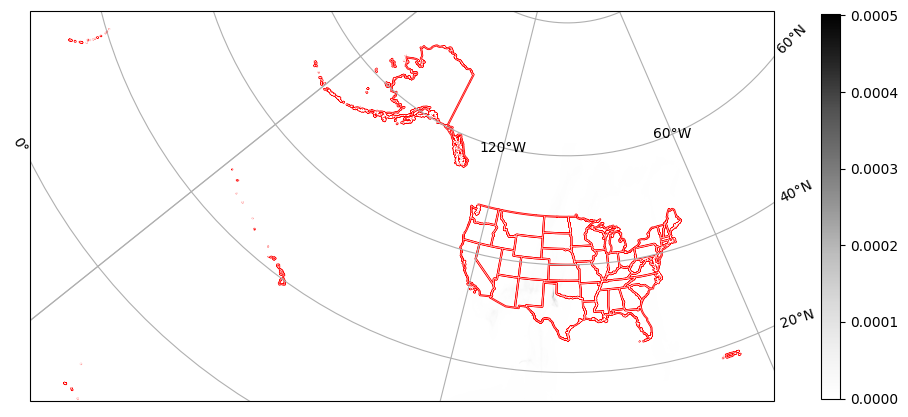

In [45]:
def plot_mass_den(mass_den):
    fig = plt.figure(figsize=(12,10))
    #ax = plt.axes(projection=projection)
    #img = ax.contourf(x, y, surface_tmp,250,vmin=min_tmp, vmax=max_tmp)
    proj = get_proj()
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    states = get_states(proj)
    states.boundary.plot(ax=ax, edgecolor='red', linewidth=1.5)
    img = ax.imshow(mass_den, origin='lower', extent=(x[0], x[-1], y[0], y[-1]), cmap='Greys')
    #ax.coastlines())
    #ax.add_feature(cfeature.BORDERS)
    img.set_clim(min_tmp, max_tmp)
    states.boundary.plot(ax=ax, edgecolor='white', linewidth=.25)
    cb = plt.colorbar(img, shrink=0.5)
    ax.gridlines(draw_labels=True)
    plt.show()

plot_mass_den(mass_den)

In [39]:
hr = str(dt.hour).zfill(2)                                                                                                                               
day = str(dt.day).zfill(2)                                                                                                                               
mo = str(dt.month).zfill(2)                                                                                                                              
yr = str(dt.year)                                                                                                                                        
url = "s3://hrrrzarr/sfc/{}{}{}/{}{}{}_{}z_anl.zarr".format(yr,mo,day,yr,mo,day,hr)    

fs = s3fs.S3FileSystem(anon=True)
store = zarr.open(s3fs.S3Map(url, s3=fs))

mass_den = store["entire_atmosphere_single_layer/COLMD/entire_atmosphere_single_layer/COLMD"]

x  = store["entire_atmosphere_single_layer/COLMD/projection_x_coordinate"]
y = store["entire_atmosphere_single_layer/COLMD/projection_x_coordinate"]
print(mass_den.shape)
min_tmp = np.min(mass_den)
max_tmp = np.max(mass_den)

(1059, 1799)
